## This file is for the pentultimate development of this 4-Level Model

##### TRAINING SUBSECTION

In [1]:
'''NOTE Load in the training data for level-0 models'''

import _Data_Processing
import joblib
from importlib import reload

'''
this function returns 7 objects:
	data: sets of data as X_train, X_val, X_ind, y_train, y_val, y_ind
	feature_list: list of all feature names with a column index (dict)
'''

reload(_Data_Processing)

lstm_format = False

X, X_train, X_val, X_ind,\
y, y_train, y_val, y_ind,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_full.csv'
	,indp_size  =		0.01
	,test_size  =		0.20
	,shfl_splt	=		False
	,t_start    =		570
	,t_end		=		720
	,mod_type	=		'Area_Classification'
	,target_t	=		30
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Standard'
	,frmt_lstm	=		lstm_format
	,keep_price =		True
	,optm_data	=		True
    ,indices	=		0
)
joblib.dump(scaler, 'scaler/tmp.joblib')

Trying to load CSV file into DataFrame...
loaded chunk 1 of size: 125400164 -> 64675164
loaded chunk 2 of size: 125400164 -> 64575164
loaded chunk 3 of size: 125400164 -> 64675164
loaded chunk 4 of size: 125400164 -> 64675164
loaded chunk 5 of size: 125400164 -> 64675164
loaded chunk 6 of size: 125400164 -> 64675164
loaded chunk 7 of size: 125400164 -> 64675164
loaded chunk 8 of size: 125400164 -> 64575164
loaded chunk 9 of size: 125400164 -> 64675164
loaded chunk 10 of size: 7905380 -> 3951196
concat chunks
concatted chunks
Success.
Size of dataset:	586152276
Trying to drop unused targets...Success.
Trying to collect indices of wanted times...Success...

# of Samples:	226576

# of Features:	519

Target:		tc_2a_30m

Trying to split DataFrame into X and y...Success.
Trying to collect all feature names and indices...Success.
Trying to clean up...Success.
Trying to encode y and make class weights...Failed [NON-FATAL: NOT IMPLEMENTED]
Trying to standardize all featurespace from training fe

['scaler/tmp.joblib']

In [2]:
'''NOTE Shred the data to run parallel to desired level-0 structure'''

import _Data_Rotating
from importlib import reload
'''
This function returns 4 items.
-	2D array of X partitions, by featurespace and samplespace
-	1D array of index-lists for each featurespace-partition specific features
-	1D array of featurespace-partition specific rotation transformer functions
-	1D array of y partitions for each samplespace partition.
'''

reload(_Data_Rotating)

X_train_parts, X_find_parts, X_trans_parts, y_parts = _Data_Rotating.rotate_partitions(
	X				=	X_train
	,y				=	y_train
	,n_feat_parts	=	8
	,feat_subsets	=	feature_subsets
	,feat_part_type	=	'by_subset'
	,fraction_feats	=	0.75
	,no_feat_overlap=	False
	,feats_for_all	=	[]
	,rotation_type	=	'PCA'
	,rotation_filter=	False
	,filter_type	=	'Retention'
	,filter_value	=	0.95
	,n_sample_parts	=	1
	,smpl_part_type	=	'Even'
	,sample_overlap	=	0.9
	,sample_shuffle	=	False
	,lstm_format	=	lstm_format
)

2025-02-03 10:37:00.231182: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-03 10:37:00.369931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738597020.430455   20275 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738597020.448711   20275 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 10:37:00.594700: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Custom parameters selected.
nn	-	{'optimizer_type': 'Adam', 'optimizer_kwarg': {'learning_rate': 0.0005}, 'time_steps': 5, 'LSTM': False, 'shuffle_train': True, 'epochs': 5, 'rlr_patience': 20, 'architecture': 'default_deep'}
Running on: GPU



I0000 00:00:1738597023.504182   20275 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1962 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Training model #1
Running on: GPU

Epoch 1/5


I0000 00:00:1738597027.845564   20418 service.cc:148] XLA service 0x7ff51c00c690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738597027.846060   20418 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 3GB, Compute Capability 6.1
2025-02-03 10:37:07.928654: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738597028.316697   20418 cuda_dnn.cc:529] Loaded cuDNN version 90300


 49/616 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4971 - loss: 0.8461 - precision: 0.4977 - recall: 0.4815

I0000 00:00:1738597030.776967   20418 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


616/616 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5024 - loss: 0.8188 - precision: 0.5152 - recall: 0.5052 - val_accuracy: 0.5438 - val_loss: 0.6881 - val_precision: 0.5701 - val_recall: 0.4424 - learning_rate: 5.0000e-04
Epoch 2/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5060 - loss: 0.7292 - precision: 0.5174 - recall: 0.5149 - val_accuracy: 0.5310 - val_loss: 0.6929 - val_precision: 0.5762 - val_recall: 0.3168 - learning_rate: 5.0000e-04
Epoch 3/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4998 - loss: 0.7125 - precision: 0.5103 - recall: 0.5058 - val_accuracy: 0.5458 - val_loss: 0.6879 - val_precision: 0.5641 - val_recall: 0.4965 - learning_rate: 5.0000e-04
Epoch 4/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5002 - loss: 0.7058 - precision: 0.5130 - recall: 0.4860 - val_accuracy: 0.5141 - val_loss: 0.6894 - val_precision: 0.5543 - val_recall: 0.2600 - learning_rate: 5.0000e-04
Epoch 5/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accurac

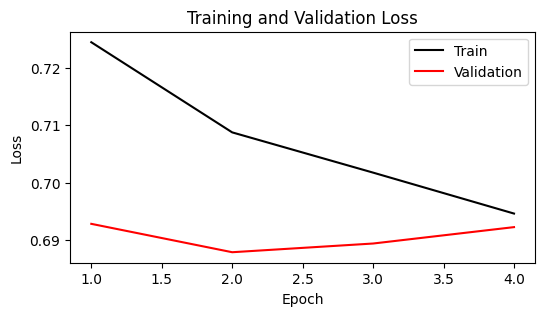

Running on: GPU

Training model #2
Running on: GPU

Epoch 1/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5064 - loss: 0.8500 - precision: 0.5225 - recall: 0.4979 - val_accuracy: 0.4903 - val_loss: 0.6982 - val_precision: 0.5025 - val_recall: 0.4303 - learning_rate: 5.0000e-04
Epoch 2/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4941 - loss: 0.7480 - precision: 0.5078 - recall: 0.4954 - val_accuracy: 0.4995 - val_loss: 0.6958 - val_precision: 0.5296 - val_recall: 0.1997 - learning_rate: 5.0000e-04
Epoch 3/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5017 - loss: 0.7211 - precision: 0.5105 - recall: 0.5028 - val_accuracy: 0.5390 - val_loss: 0.6916 - val_precision: 0.5470 - val_recall: 0.5787 - learning_rate: 5.0000e-04
Epoch 4/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5073 - loss: 0.7075 - precision: 0.5197 - recall: 0.5281 - val_accuracy: 0.5087 - val_loss: 0.6925 - val_precision: 0.5332 - val_recall: 0.3234 - learning_rate: 5.0000e-0

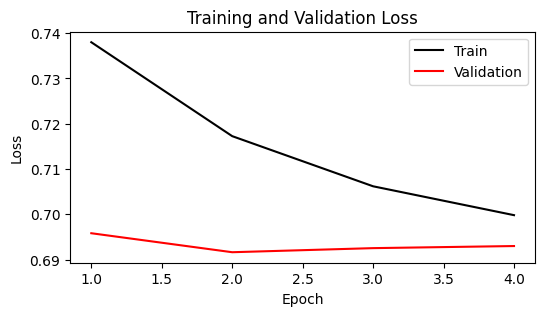

Running on: GPU

Training model #3
Running on: GPU

Epoch 1/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5029 - loss: 0.8206 - precision: 0.5138 - recall: 0.4771 - val_accuracy: 0.5071 - val_loss: 0.6986 - val_precision: 0.5758 - val_recall: 0.1413 - learning_rate: 5.0000e-04
Epoch 2/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5043 - loss: 0.7337 - precision: 0.5183 - recall: 0.4780 - val_accuracy: 0.4845 - val_loss: 0.7028 - val_precision: 0.4430 - val_recall: 0.0274 - learning_rate: 5.0000e-04
Epoch 3/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5079 - loss: 0.7127 - precision: 0.5154 - recall: 0.4737 - val_accuracy: 0.4921 - val_loss: 0.6953 - val_precision: 0.5595 - val_recall: 0.0368 - learning_rate: 5.0000e-04
Epoch 4/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5149 - loss: 0.7023 - precision: 0.5311 - recall: 0.5021 - val_accuracy: 0.4927 - val_loss: 0.6946 - val_precision: 0.5561 - val_recall: 0.0446 - learning_rate: 5.0000e-0

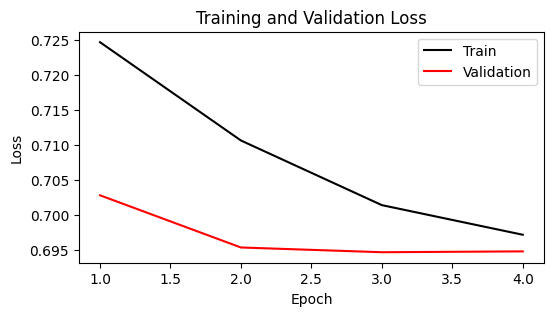

Running on: GPU

Training model #4
Running on: GPU

Epoch 1/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5068 - loss: 0.8204 - precision: 0.5140 - recall: 0.5541 - val_accuracy: 0.5159 - val_loss: 0.6990 - val_precision: 0.5148 - val_recall: 0.9456 - learning_rate: 5.0000e-04
Epoch 2/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5043 - loss: 0.7341 - precision: 0.5208 - recall: 0.5589 - val_accuracy: 0.5085 - val_loss: 0.6952 - val_precision: 0.5156 - val_recall: 0.6609 - learning_rate: 5.0000e-04
Epoch 3/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5036 - loss: 0.7133 - precision: 0.5148 - recall: 0.5369 - val_accuracy: 0.5133 - val_loss: 0.6925 - val_precision: 0.5207 - val_recall: 0.6194 - learning_rate: 5.0000e-04
Epoch 4/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5136 - loss: 0.7008 - precision: 0.5248 - recall: 0.5675 - val_accuracy: 0.5081 - val_loss: 0.6948 - val_precision: 0.5459 - val_recall: 0.2330 - learning_rate: 5.0000e-0

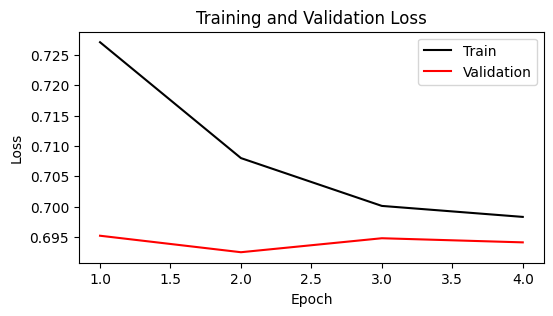

Running on: GPU

Training model #5
Running on: GPU

Epoch 1/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5027 - loss: 0.8269 - precision: 0.5077 - recall: 0.5799 - val_accuracy: 0.5236 - val_loss: 0.6967 - val_precision: 0.5216 - val_recall: 0.8375 - learning_rate: 5.0000e-04
Epoch 2/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5003 - loss: 0.7349 - precision: 0.5130 - recall: 0.5655 - val_accuracy: 0.5191 - val_loss: 0.6938 - val_precision: 0.5409 - val_recall: 0.4009 - learning_rate: 5.0000e-04
Epoch 3/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5195 - loss: 0.7089 - precision: 0.5319 - recall: 0.5963 - val_accuracy: 0.5234 - val_loss: 0.6906 - val_precision: 0.5613 - val_recall: 0.3156 - learning_rate: 5.0000e-04
Epoch 4/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5143 - loss: 0.7009 - precision: 0.5251 - recall: 0.5945 - val_accuracy: 0.5282 - val_loss: 0.6903 - val_precision: 0.5488 - val_recall: 0.4405 - learning_rate: 5.0000e-04

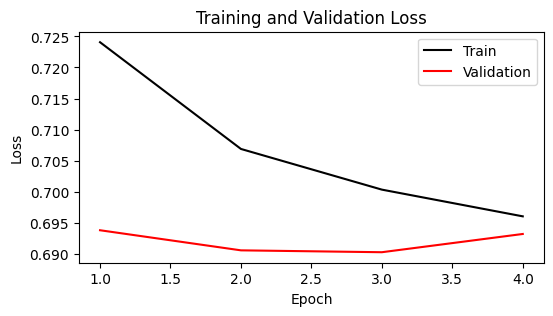

Running on: GPU

Training model #6
Running on: GPU

Epoch 1/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4945 - loss: 0.7853 - precision: 0.5169 - recall: 0.4658 - val_accuracy: 0.4895 - val_loss: 0.7093 - val_precision: 0.5263 - val_recall: 0.0274 - learning_rate: 5.0000e-04
Epoch 2/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5058 - loss: 0.7196 - precision: 0.5170 - recall: 0.4505 - val_accuracy: 0.4961 - val_loss: 0.6990 - val_precision: 0.5862 - val_recall: 0.0532 - learning_rate: 5.0000e-04
Epoch 3/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5185 - loss: 0.7012 - precision: 0.5351 - recall: 0.4783 - val_accuracy: 0.4989 - val_loss: 0.6974 - val_precision: 0.6125 - val_recall: 0.0576 - learning_rate: 5.0000e-04
Epoch 4/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5147 - loss: 0.6960 - precision: 0.5359 - recall: 0.4683 - val_accuracy: 0.4943 - val_loss: 0.6969 - val_precision: 0.5906 - val_recall: 0.0395 - learning_rate: 5.0000e-0

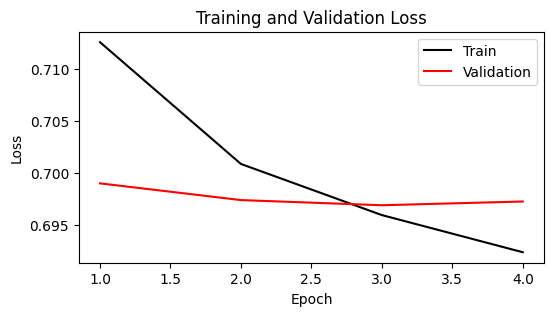

Running on: GPU

Training model #7
Running on: GPU

Epoch 1/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5053 - loss: 0.8749 - precision: 0.5202 - recall: 0.5643 - val_accuracy: 0.5462 - val_loss: 0.6985 - val_precision: 0.5566 - val_recall: 0.5579 - learning_rate: 5.0000e-04
Epoch 2/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4966 - loss: 0.7491 - precision: 0.5120 - recall: 0.5451 - val_accuracy: 0.5472 - val_loss: 0.6936 - val_precision: 0.5608 - val_recall: 0.5329 - learning_rate: 5.0000e-04
Epoch 3/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5090 - loss: 0.7099 - precision: 0.5224 - recall: 0.5732 - val_accuracy: 0.5584 - val_loss: 0.6896 - val_precision: 0.5792 - val_recall: 0.5023 - learning_rate: 5.0000e-04
Epoch 4/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5159 - loss: 0.6986 - precision: 0.5219 - recall: 0.5750 - val_accuracy: 0.5442 - val_loss: 0.6894 - val_precision: 0.5725 - val_recall: 0.4327 - learning_rate: 5.0000e-0

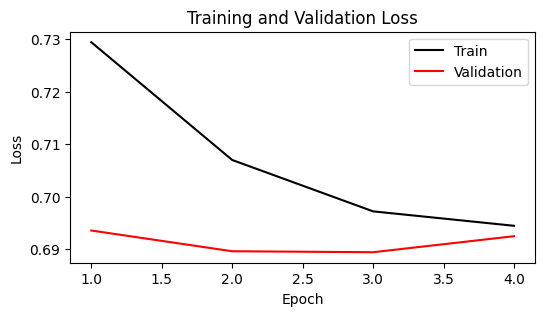

Running on: GPU

Training model #8
Running on: GPU

Epoch 1/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5032 - loss: 0.8749 - precision: 0.5238 - recall: 0.4518 - val_accuracy: 0.4931 - val_loss: 0.7275 - val_precision: 0.6316 - val_recall: 0.0235 - learning_rate: 5.0000e-04
Epoch 2/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5155 - loss: 0.7337 - precision: 0.5353 - recall: 0.4737 - val_accuracy: 0.4911 - val_loss: 0.7052 - val_precision: 0.5581 - val_recall: 0.0282 - learning_rate: 5.0000e-04
Epoch 3/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5087 - loss: 0.7127 - precision: 0.5275 - recall: 0.4675 - val_accuracy: 0.4903 - val_loss: 0.6994 - val_precision: 0.6486 - val_recall: 0.0094 - learning_rate: 5.0000e-04
Epoch 4/5
616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5107 - loss: 0.7038 - precision: 0.5240 - recall: 0.4732 - val_accuracy: 0.5057 - val_loss: 0.6964 - val_precision: 0.6176 - val_recall: 0.0904 - learning_rate: 5.0000e-0

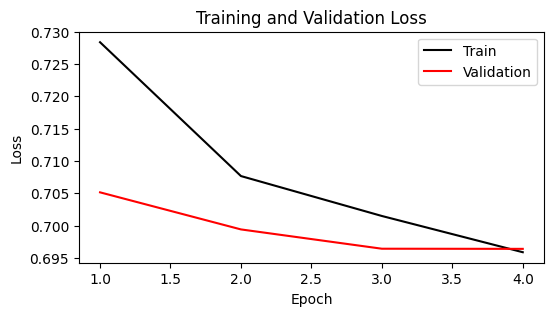

In [3]:
'''NOTE Begin training for each level-0 model'''

import _Modelset_Training
from importlib import reload

'''
Function returns a 3D list of trained models that are fit to the resepective dataset.
	Dim1:	Featurespace, here are the subsetctions/partitions for each unique set of features
	Dim2:	Samplespace, here are the subsetctions/partitions for each unique set of samples
	Dim3:	Modelspace, here are the individual models trained on a unique partition
'''
reload(_Modelset_Training)

models = _Modelset_Training.train_models(
	model_types	=	['nn']
	,data_parts	=	X_train_parts
	,findx_parts=	X_find_parts
	,trans_parts=	X_trans_parts
	,trgt_parts	=	y_parts
	,X_valid	=	X_val
	,y_valid	=	y_val
	,param_mode	=	'custom'
	,cst_mod_prm=	[{
		'optimizer_type'	:	'Adam'
		,'optimizer_kwarg':{
			'learning_rate'	:	0.0005
			#,'momentum'		:	0.9
			}
		,'time_steps'		:	5
		,'LSTM'				:	False
		,'shuffle_train'	:	True
		,'epochs'			:	5
		,'rlr_patience'		:	20
		,'architecture'	:	'default_deep'
		#,'external_cw'	:	_Utility.get_class_weights(y_train)
		}]
	,tnr_verbose=	True
	,lstm_frmt	=	lstm_format
	,use_cls_wt	=	True
)

In [4]:
'''NOTE show performances of level-0 Models'''

import _Model_Evaluation
import _Neural_Net

reload(_Model_Evaluation)
reload(_Neural_Net)

_Model_Evaluation.evaluate_models(
		models=models
		,X_findx=X_find_parts
		,X_trans=X_trans_parts
		,X_train=X_train_parts
		,y_train=y_parts
		,X_test=X_val
		,y_test=y_val
		,prfm_gnrl	=	'all'
		,prfm_stat	=	'all'
		,disp_mthd	=	'as_value'
		,test_whch	=	'independent'
		,pred_type	=	'classification'
		,lstm_frmt	=	lstm_format
)

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ -0s 3ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Dimensions of Trained Models:
	Feature Space: 8
	Sample Space: 1
	Model Space: 1


	Displaying all performances for all independent samples: (8 cases)

4

Statistics Overall:

	Split 0:
				Avg	St.Dv.	Low	High
		Accuracy	0.52	0.02	0.5	0.56
		Precision	0.57	0.03	0.51	0.62
		Recall		0.41	0.28	0.06	0.95

Statistics By Feature Space:

	Split 0:
				Avg	St.Dv.	Low	High
		Accuracy	0.55	0.0	0.55	0.55
		Precision	0.56	0.0	0.56	0.56
		Recall		0.5	0.0	0.5	0.5
	Split 1:
				Avg	St.Dv.	Low	High
		Accuracy	0.54	0.0	0.54	0.54
		Precision	0.55	0.0	0.55	0.55
		Recall		0.58	0.0	0.58	0.58
	Split 2:
				Avg	St.Dv.	Low	High
		Accuracy	0.51	0.0	0.51	0.51
		Precision	0.58	0.0	0.58	0.5

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(4989, 8)
Running on: GPU

Running on: GPU

Epoch 1/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5033 - loss: 0.7988 - precision: 0.5064 - recall: 0.4971 - val_accuracy: 0.5361 - val_loss: 0.7014 - val_precision: 0.5299 - val_recall: 0.5887 - learning_rate: 0.0010
Epoch 2/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5324 - loss: 0.7407 - precision: 0.5479 - recall: 0.5303 - val_accuracy: 0.5341 - val_loss: 0.6952 - val_precision: 0.5294 - val_recall: 0.5625 - learning_rate: 0.0010
Epoch 3/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5065 - loss: 0.7271 - precision: 0.5256 - recall: 0.5016 - val_accuracy: 0.5361 - val_loss: 0

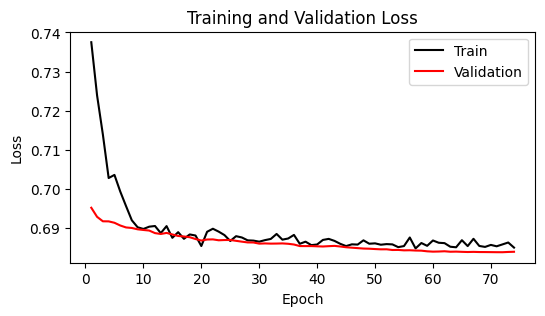

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
META-MODEL SELF TEST:
	Accuracy:	0.56
	Precision:	0.58
	Recall:		0.53


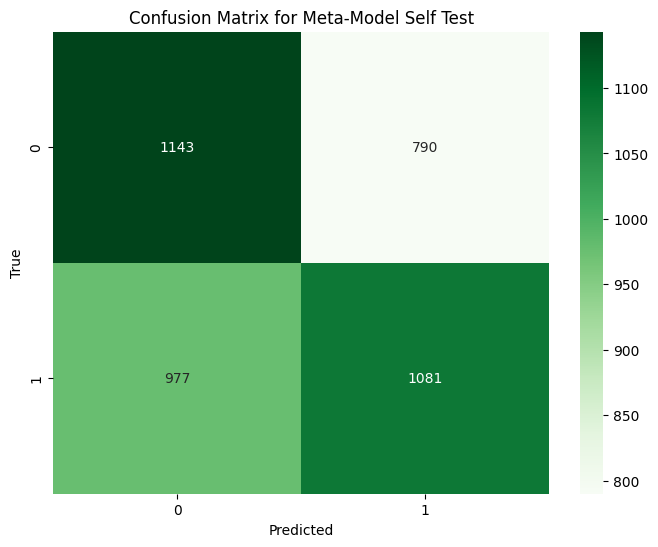

META-MODEL INDEPENDENT TEST:
	Accuracy:	0.57
	Precision:	0.56
	Recall:		0.55


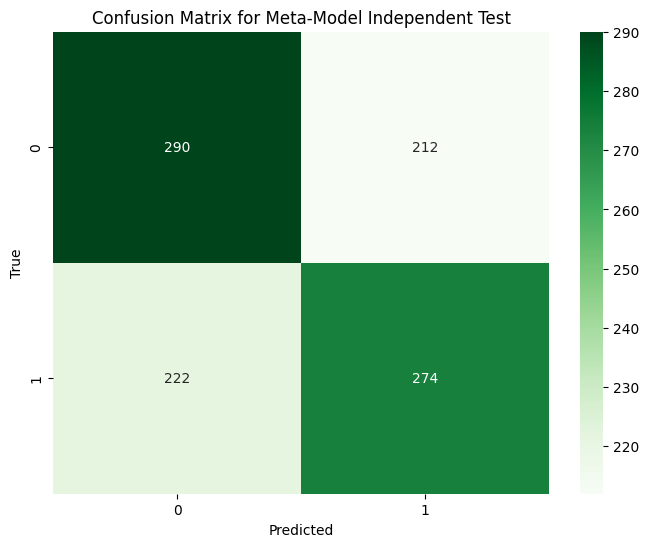

In [5]:
'''NOTE begin training for level-1 model based off of train level-0 model predictions'''

import _Metamodel
from importlib import reload
import _Utility

reload(_Metamodel)
metamodel, prediction_set = _Metamodel.train_test_meta_model(
	models		=	models
	,X_findx	=	X_find_parts
	,X_trans	=	X_trans_parts
	,X_test		=	X_val
	,y_test		=	y_val
	,val_size	=	0.2
	,shuffle	=	True
	,metam_type =	'NN'
	,use_cls_wt =	True
	,use_mm_params=	True
	,metam_params={
		'optimizer_type':	'Adam'
		,'optimizer_kwarg':{
			'learning_rate'	:	0.001
			#,'momentum':0.9
			}
		,'time_steps'		:	5
		,'LSTM'				:	False
		,'shuffle_train'	:	True
		,'epochs'			:	75
		,'batch_size'		:	30
		,'rlr_patience'		:	10
		,'architecture'	:	'default_deep'
		#,'custom_val_data'	:	(X_train, y_train)
		}
)

In [13]:
'''NOTE load in data for testing quality of level-1/2 models'''

import _Data_Processing
from importlib import reload
reload(_Data_Processing)
lstm_format = False
X_test, _, _, __,\
y_test, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		30
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Custom'
    ,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,indices	=		0
)

Trying to load CSV file into DataFrame...
loaded chunk 1 of size: 125400164 -> 64600164
loaded chunk 2 of size: 18408884 -> 9395364
concat chunks
concatted chunks
Success.
Size of dataset:	74083444
Trying to drop unused targets...Success.
Trying to collect indices of wanted times...Success...

# of Samples:	28670

# of Features:	519

Target:		tc_2a_30m

Trying to split DataFrame into X and y...Success.
Trying to collect all feature names and indices...Success.
Trying to clean up...Success.
Trying to encode y and make class weights...Failed [NON-FATAL: NOT IMPLEMENTED]
Trying to standardize all featurespace from training featurespace...Success.
Trying to drop unwanted time-range samples...Success.
	25577 Samples Dropped.

Trying to split X and y into Train/Validation/Independent...Success.
Trying to clean up...Success.
X_train:	(3031, 519).
y_train:	(3031,).
X_val:  	(31, 519).
y_val:  	(31,).
X_ind:  	(31, 519).
y_ind:  	(31,).
Terminating.


616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(19704, 8)
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


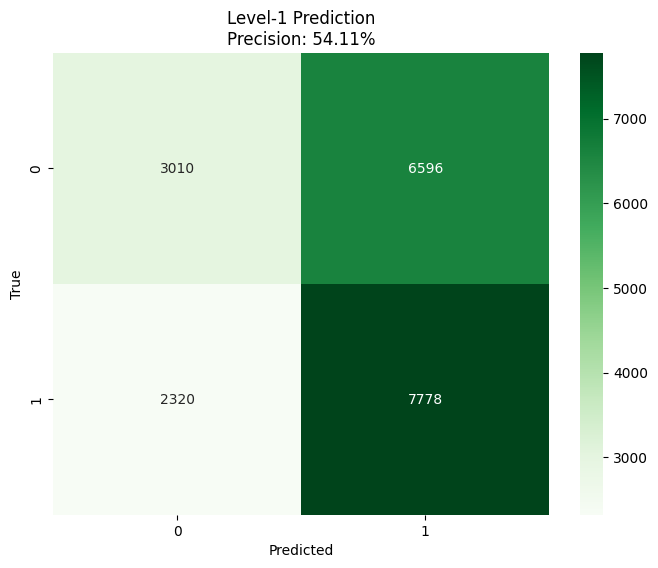

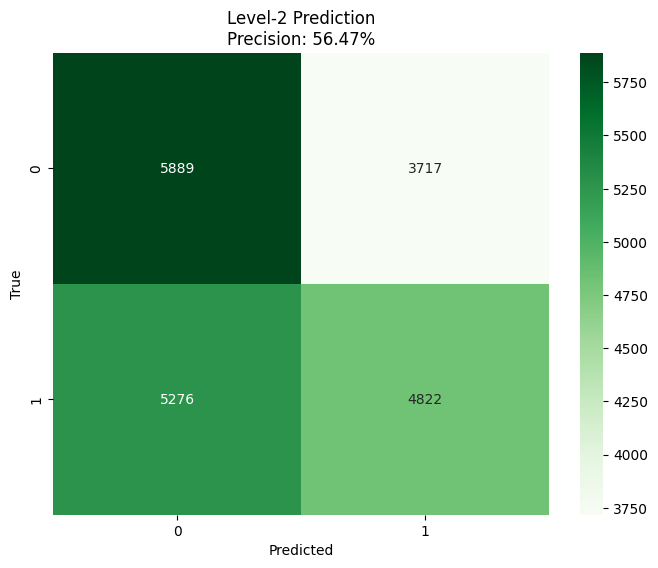

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import _Master_Model
reload(_Master_Model)
reload(_Utility)
from importlib import reload
from sklearn.svm import SVC
from _Utility import get_class_weights

shallow_master = _Master_Model.Master(
	model_depth		=	2
	,all_models 	=	[models, metamodel]
	,lvl0_formatters=	[X_find_parts, X_trans_parts]
)

pred_2 = shallow_master.master_predict(X_train)
cm_vals = _Utility.get_cm_values(y_train, pred_2)

_Utility.show_confusion_matrix(y_train,pred_2,title=f'Level-1 Prediction\nPrecision: {round(precision_score(y_train,pred_2)*100, 2)}%')

df = pd.DataFrame(X_train)
df['score'] = cm_vals
df['target'] = y_train
kept_indices = df.index[~(df['score'] % 2 == 0)].tolist()
df = df.drop(df[df['score']%2==0].index).reset_index(drop=True)
df = df.drop(columns=['score']).reset_index(drop=True)
#pd.set_option('display.max_rows',None)
co = df.corr()['target'].drop('target')
#print(co.sort_values())
p = co.nlargest(5).index.tolist()
n = co.nsmallest(5).index.tolist()
feats = p+n

df_pair = pd.DataFrame(X_train)
df_pair = df_pair.iloc[kept_indices].reset_index(drop=True)
df_pair = df_pair.iloc[:, feats]

X_svm = df_pair.values
y_svm = df['target'].values

clf = SVC(kernel='linear',C=1.0,class_weight=_Utility.get_class_weights(df['target'])).fit(X_svm, y_svm)

y_svmpred = pred_2#clf.predict(X_svm)
#'polishing' predictions based on if level-1 predicted (1)
for p in range(len(y_svmpred)):
	if(y_svmpred[p] == 1):
		y_svmpred[p] = clf.predict(X_train[p,feats].reshape(1, -1))

#_Utility.show_confusion_matrix(df['target'],y_svmpred,title=f'Level-2 Prediction\nPrecision: {round(precision_score(y_svm, y_svmpred)*100, 2)}%')
_Utility.show_confusion_matrix(y_train,y_svmpred,title=f'Level-2 Prediction\nPrecision: {round(precision_score(y_train, y_svmpred)*100, 2)}%')


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(3093, 8)
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


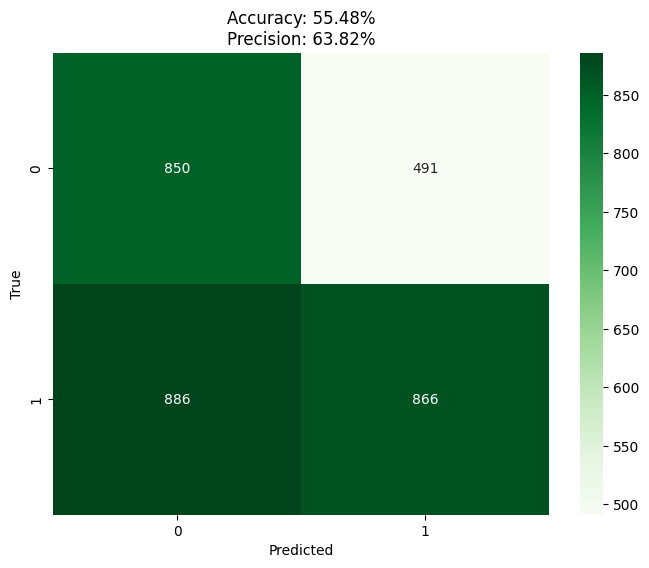

In [34]:
reload(_Master_Model)
reload(_Utility)
deep_master = _Master_Model.Master(
	model_depth		=	3
	,all_models 	=	[models, metamodel, clf]
	,lvl0_formatters=	[X_find_parts, X_trans_parts]
    ,lvl2_formatters=	[feats]
)

y_3pred = deep_master.master_predict(X_test)

_Utility.show_confusion_matrix(y_test, y_3pred, title=f'Accuracy: {_Utility.get_accuracy(y_test, y_3pred)}\nPrecision: {_Utility.get_precision(y_test, y_3pred)}')

In [40]:
import _Master_Model
from importlib import reload
reload(_Master_Model)
deep_master.save_model()

Folder tree generated successfully.
PATH: tmp_model/level_0/model_0_0_0
keras saving complete
PATH: tmp_model/level_0/model_1_0_0
keras saving complete
PATH: tmp_model/level_0/model_2_0_0
keras saving complete
PATH: tmp_model/level_0/model_3_0_0
keras saving complete
PATH: tmp_model/level_0/model_4_0_0
keras saving complete
PATH: tmp_model/level_0/model_5_0_0
keras saving complete
PATH: tmp_model/level_0/model_6_0_0
keras saving complete
PATH: tmp_model/level_0/model_7_0_0
keras saving complete
Level-1 model saving to -> tmp_model/level_1/model_0.keras could not save properly:
'NN' object has no attribute 'save'
